In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


### Full adata interactions

In [4]:
# sample = 'slideseq'
# sample = 'lymphKO4b'
sample = 'lymph1'

In [5]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_{sample}_visiumHD.h5ad')
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [6]:
tfh_markers = ['Icos', 'Bcl6', 'Cxcr5', 'Pdcd1']
th2_markers = ['Il2ra', 'Il2rb', 'Il2rg', 'Gata3']

In [7]:
data = {}
betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

for gene in th2_markers:
    data[gene] = pd.concat([
        pd.read_parquet(betadir + f'mouse_lymph1{part}_visiumHD/' + gene + '_betadata.parquet') for part in ['a', 'b', 'c', 'd']
    ])

data.keys()

dict_keys(['Il2ra', 'Il2rb', 'Il2rg', 'Gata3'])

In [8]:
# # find transferred cells (Prdm1+ Th2)
tmp = adata[:, ['Prdm1']].to_df(layer='raw_count')
prdm1 = tmp[tmp['Prdm1'] > 0].index

th2 = adata[((adata.obs['cell_type'] == 'Th2')), :].obs.index

# transferred = set(th2) & set(prdm1)
# transferred = list(transferred)
# len(transferred)

transferred = list(th2)
len(transferred)

433

In [9]:
data = {k: v.loc[transferred, :] for k, v in data.items()}

In [10]:
th2_betas = pd.concat([data[gene].loc[adata.obs.cell_type == 'Th2'] for gene in th2_markers], axis=0)
th2_betas = th2_betas.fillna(0)
th2_interxns = th2_betas[[x for x in th2_betas.columns if '$' in x]]

In [11]:
def plot_lr_interactions(interactions_df, cell_type):
    """
    Plot top and bottom 20 ligand-receptor interactions for a given cell type using boxplots.
    
    Parameters:
    -----------
    interactions_df : pandas.DataFrame
        DataFrame containing interaction betas
    cell_type : str
        Name of the cell type to analyze
    """
    # Compute mean interaction for each LR pair
    means = interactions_df.mean(axis=0)
    
    # Get top and bottom 20
    top20 = means.sort_values(ascending=False)[means > 0].head(20).index
    bottom20 = means.sort_values(ascending=True)[means < 0].head(20).index
    selected = list(top20) + list(bottom20)
    # Subset and melt for seaborn
    plot_df = interactions_df[selected].melt(var_name='Ligand-Receptor', value_name='Beta')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Plot top 20 interactions
    top_df = plot_df[plot_df['Ligand-Receptor'].isin(top20)]
    top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=top_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Reds',
        showfliers=False,
        ax=ax1
    )
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
    ax1.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax1.set_xlabel('Interaction Beta', fontsize=14)
    ax1.set_title(f'Top 20 LR Interactions Promoting {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Plot bottom 20 interactions
    bottom_df = plot_df[plot_df['Ligand-Receptor'].isin(bottom20)]
    bottom_df['Ligand-Receptor'] = bottom_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=bottom_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Blues',
        showfliers=False,
        ax=ax2
    )
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    ax2.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax2.set_xlabel('Interaction Beta', fontsize=14)
    ax2.set_title(f'Bottom 20 LR Interactions Inhibiting {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Add overall title
    # fig.suptitle(f'LR Interactions in {cell_type}', fontsize=18, weight='bold', y=1.05)
    
    # Color CCR4 text blue if present
    for ax in [ax1, ax2]:
        for label in ax.get_yticklabels():
            if 'Ccr4' in label.get_text():
                label.set_color('blue')
    
    plt.tight_layout()
    sns.despine()

/tmp/ipykernel_64065/557485656.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')
/tmp/ipykernel_64065/557485656.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_64065/557485656.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_64065/557485656.py:44: SettingWithCopyWarning: 
A value is trying to be se

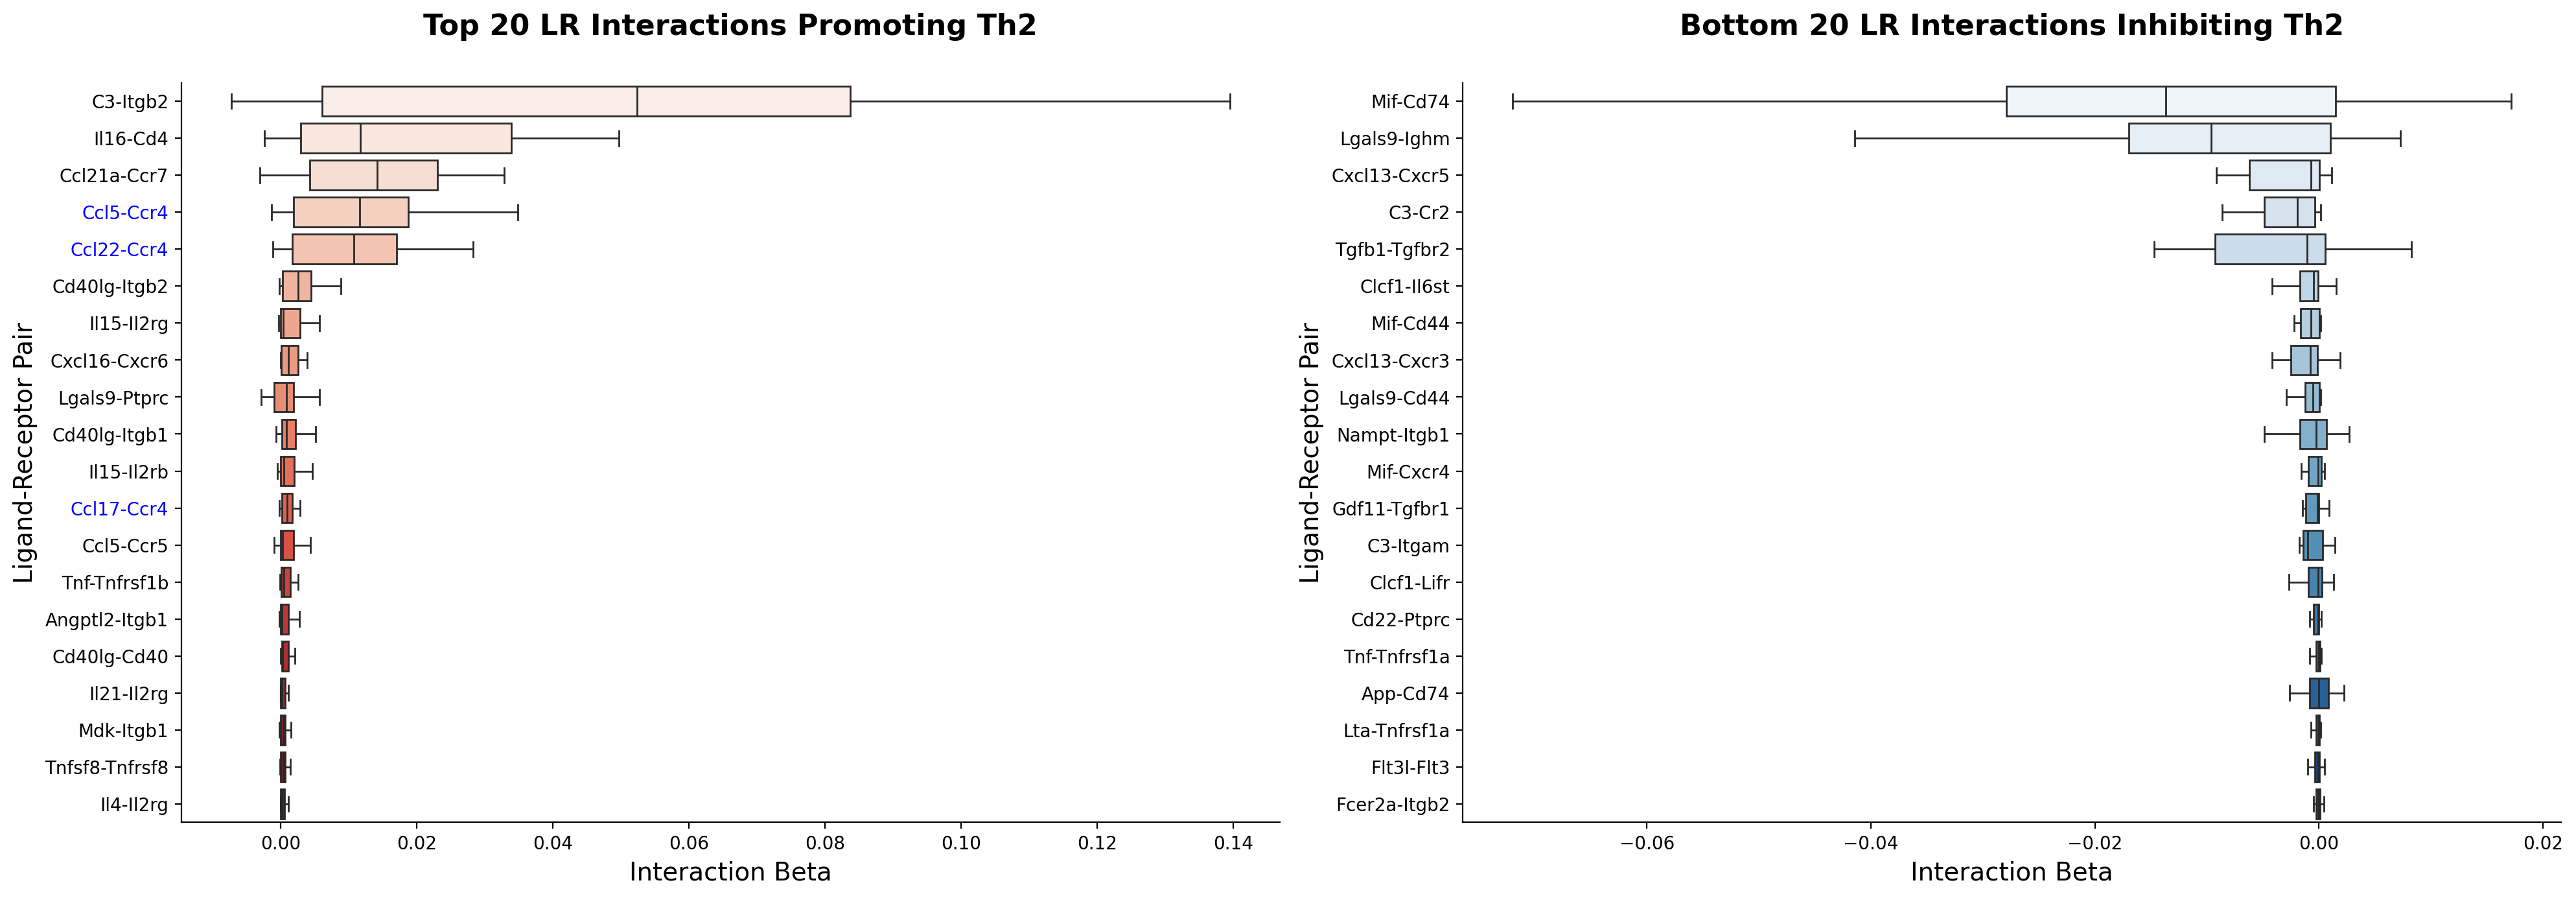

In [12]:
plot_lr_interactions(th2_interxns, 'Th2')
# plt.savefig(f'{sample}_th2_betas.svg', bbox_inches='tight', dpi=300, transparent=True, format='svg')

/tmp/ipykernel_64065/557485656.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')
/tmp/ipykernel_64065/557485656.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_64065/557485656.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_64065/557485656.py:44: SettingWithCopyWarning: 
A value is trying to be se

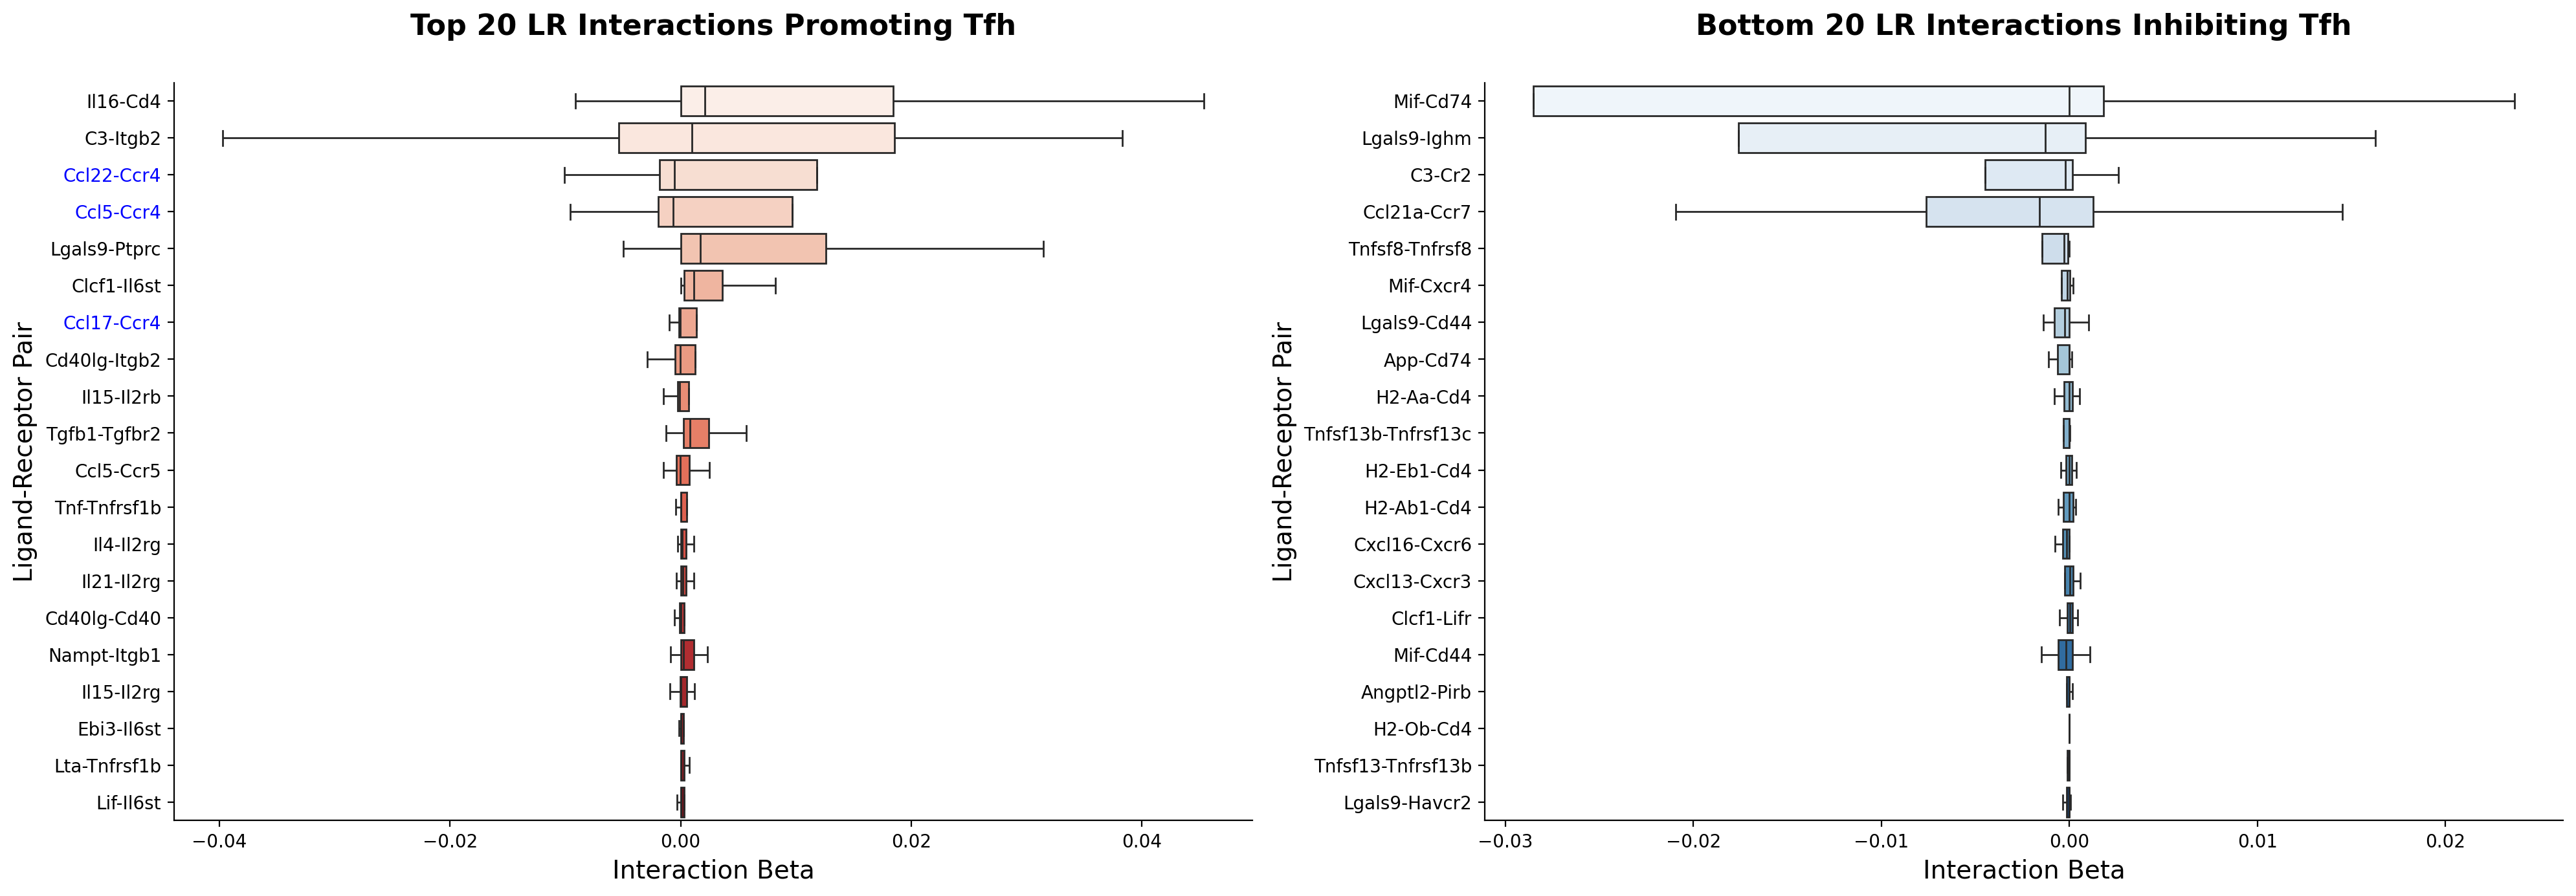

In [13]:
tfh_cells = adata[adata.obs['cell_type'] == 'Tfh'].obs.index
betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

data = {}
for gene in tfh_markers:
    data[gene] = pd.concat([
        pd.read_parquet(betadir + f'mouse_lymph1{part}_visiumHD/' + gene + '_betadata.parquet') for part in ['a', 'b', 'c', 'd']
    ])

data = {k: v.loc[tfh_cells, :] for k, v in data.items()}

tfh_betas = pd.concat([data[gene] for gene in tfh_markers], axis=0)
tfh_betas = tfh_betas.fillna(0)
tfh_interxns = tfh_betas[[x for x in tfh_betas.columns if '$' in x]]

plot_lr_interactions(tfh_interxns, 'Tfh')
# plt.savefig(f'{sample}_tfh_betas.svg', bbox_inches='tight', dpi=300, transparent=True, format='svg')

### Weighted interactions (1 part)

In [14]:
tfh_markers = ['Icos', 'Bcl6', 'Cxcr5', 'Pdcd1']
th2_markers = ['Il2ra', 'Il2rb', 'Il2rg', 'Gata3']

In [8]:
data = {
    gene : pd.read_parquet(betadir + gene + '_betadata.parquet') for gene in tfh_markers + th2_markers
}

In [9]:
rw_ligands_0 = adata.uns.get('received_ligands')
rw_tfligands_0 = adata.uns.get('received_ligands_tfl')
cell_thresholds = adata.uns.get('cell_thresholds')
gene_mtx_1 = adata.to_df(layer='imputed_count')

In [10]:
from spaceoracle.models.parallel_estimators import get_filtered_df, received_ligands

gex_df = get_filtered_df(       # mask out receptors too
    counts_df=pd.DataFrame(
        gene_mtx_1, 
        index=adata.obs_names, 
        columns=adata.var_names
    ),
    cell_thresholds=cell_thresholds,
    genes=adata.var_names
)[adata.var_names] 

2025-06-23 15:14:11.323598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [11]:
tfh_betas = pd.concat([data[gene].loc[adata.obs.cell_type == 'Tfh'] for gene in tfh_markers], axis=0)
tfh_betas = tfh_betas.fillna(0)
tfh_interxns = tfh_betas[[x for x in tfh_betas.columns if '$' in x]]

In [12]:
gene_pairs = [pair.replace('beta_', '').split('$') for pair in tfh_interxns.columns] 
gene_pairs = np.array(gene_pairs)
gene_pairs.shape

(124, 2)

In [26]:
# rec_expr = gex_df.loc[tfh_interxns.index, gene_pairs[:, 1]]
# rec_expr.shape

rec_expr = cell_thresholds.loc[tfh_interxns.index, gene_pairs[:, 1]].astype(bool).astype(int)
rec_expr.shape

(716, 124)

In [24]:
# lig_expr = rw_ligands_0.loc[tfh_interxns.index, gene_pairs[:, 0]]
# lig_expr.shape

lig_expr = cell_thresholds.loc[tfh_interxns.index, gene_pairs[:, 0]].astype(bool).astype(int)
lig_expr.shape

(716, 124)

In [27]:
tfh_interxns = rec_expr.values * lig_expr.values * tfh_interxns
tfh_interxns.shape

(716, 124)

In [28]:
tfh_betas = pd.concat([data[gene].loc[adata.obs.cell_type == 'Tfh'] for gene in tfh_markers], axis=0)
tfh_betas = tfh_betas.fillna(0)
tfh_interxns = tfh_betas[[x for x in tfh_betas.columns if '$' in x]]

In [30]:
def plot_lr_interactions(interactions_df, cell_type):
    """
    Plot top and bottom 20 ligand-receptor interactions for a given cell type using boxplots.
    
    Parameters:
    -----------
    interactions_df : pandas.DataFrame
        DataFrame containing interaction betas
    cell_type : str
        Name of the cell type to analyze
    """
    # Compute mean interaction for each LR pair
    means = interactions_df.mean(axis=0)
    
    # Get top and bottom 20
    top20 = means.sort_values(ascending=False)[means > 0].head(20).index
    bottom20 = means.sort_values(ascending=True)[means < 0].head(20).index
    selected = list(top20) + list(bottom20)
    # Subset and melt for seaborn
    plot_df = interactions_df[selected].melt(var_name='Ligand-Receptor', value_name='Beta')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Plot top 20 interactions
    top_df = plot_df[plot_df['Ligand-Receptor'].isin(top20)]
    top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=top_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Reds',
        showfliers=False,
        ax=ax1
    )
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
    ax1.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax1.set_xlabel('Interaction Beta', fontsize=14)
    ax1.set_title(f'Top 20 LR Interactions Promoting {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Plot bottom 20 interactions
    bottom_df = plot_df[plot_df['Ligand-Receptor'].isin(bottom20)]
    bottom_df['Ligand-Receptor'] = bottom_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=bottom_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Blues',
        showfliers=False,
        ax=ax2
    )
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    ax2.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax2.set_xlabel('Interaction Beta', fontsize=14)
    ax2.set_title(f'Bottom 20 LR Interactions Inhibiting {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Add overall title
    # fig.suptitle(f'LR Interactions in {cell_type}', fontsize=18, weight='bold', y=1.05)
    
    # Color CCR4 text blue if present
    for ax in [ax1, ax2]:
        for label in ax.get_yticklabels():
            if 'Ccr4' in label.get_text():
                label.set_color('blue')
    
    plt.tight_layout()
    sns.despine()

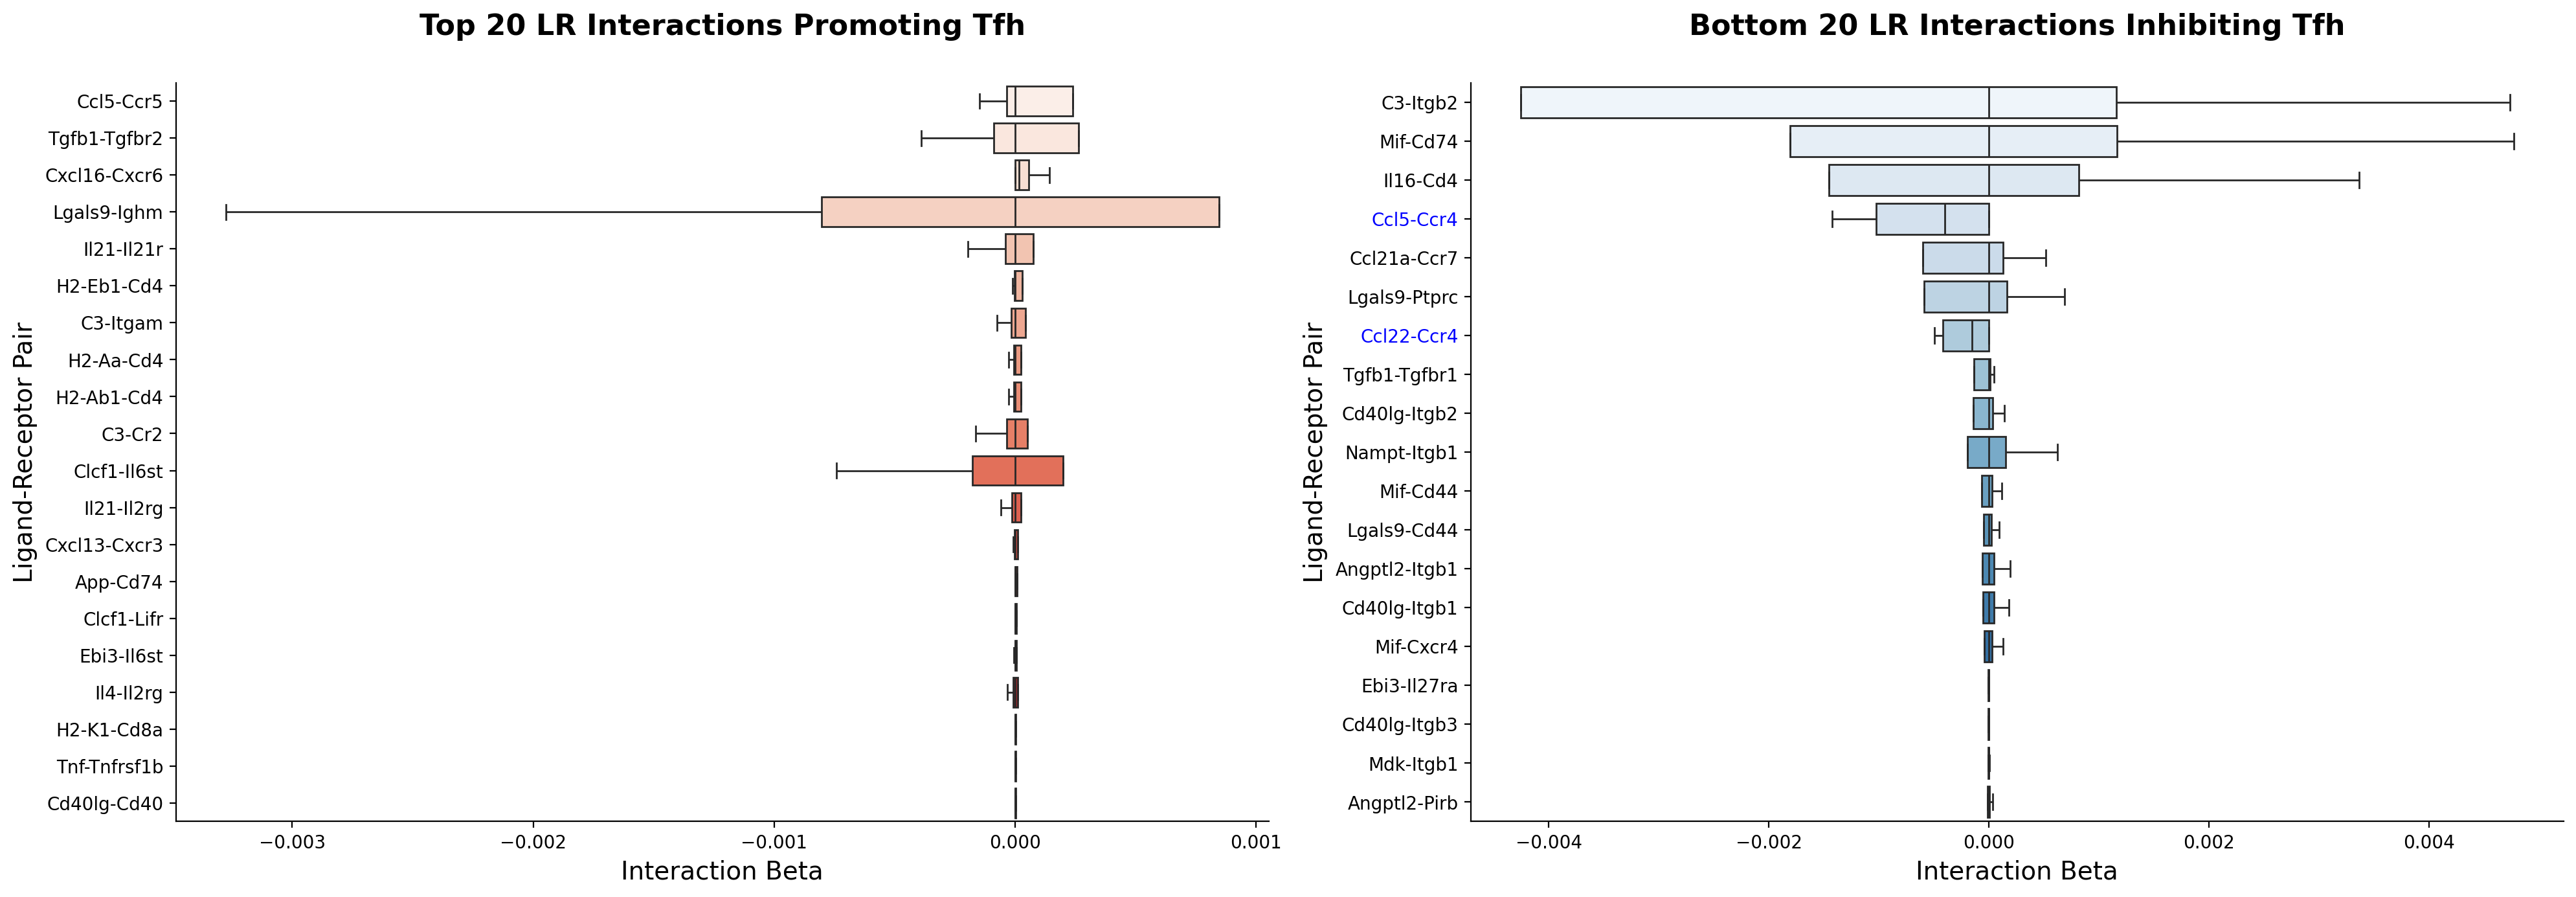

In [30]:
plot_lr_interactions(tfh_interxns, 'Tfh')
plt.savefig(f'{sample}_tfh_betas.svg', bbox_inches='tight', dpi=300, transparent=True, format='svg')

In [51]:
th2_betas = pd.concat([data[gene].loc[adata.obs.cell_type == 'Th2'] for gene in th2_markers], axis=0)
th2_betas = th2_betas.fillna(0)
th2_interxns = th2_betas[[x for x in th2_betas.columns if '$' in x]]

In [52]:
gene_pairs = [pair.replace('beta_', '').split('$') for pair in th2_interxns.columns] 
gene_pairs = np.array(gene_pairs)
gene_pairs.shape

(161, 2)

In [53]:
rec_expr = gex_df.loc[th2_interxns.index, gene_pairs[:, 1]]
rec_expr.shape

(416, 161)

In [54]:
lig_expr = rw_ligands_0.loc[th2_interxns.index, gene_pairs[:, 0]]
lig_expr.shape

(416, 161)

In [55]:
th2_interxns = rec_expr.values * lig_expr.values * th2_interxns
th2_interxns.shape

(416, 161)

In [56]:
th2_betas = pd.concat([data[gene].loc[adata.obs.cell_type == 'Th2'] for gene in th2_markers], axis=0)
th2_betas = th2_betas.fillna(0)
th2_interxns = th2_betas[[x for x in th2_betas.columns if '$' in x]]

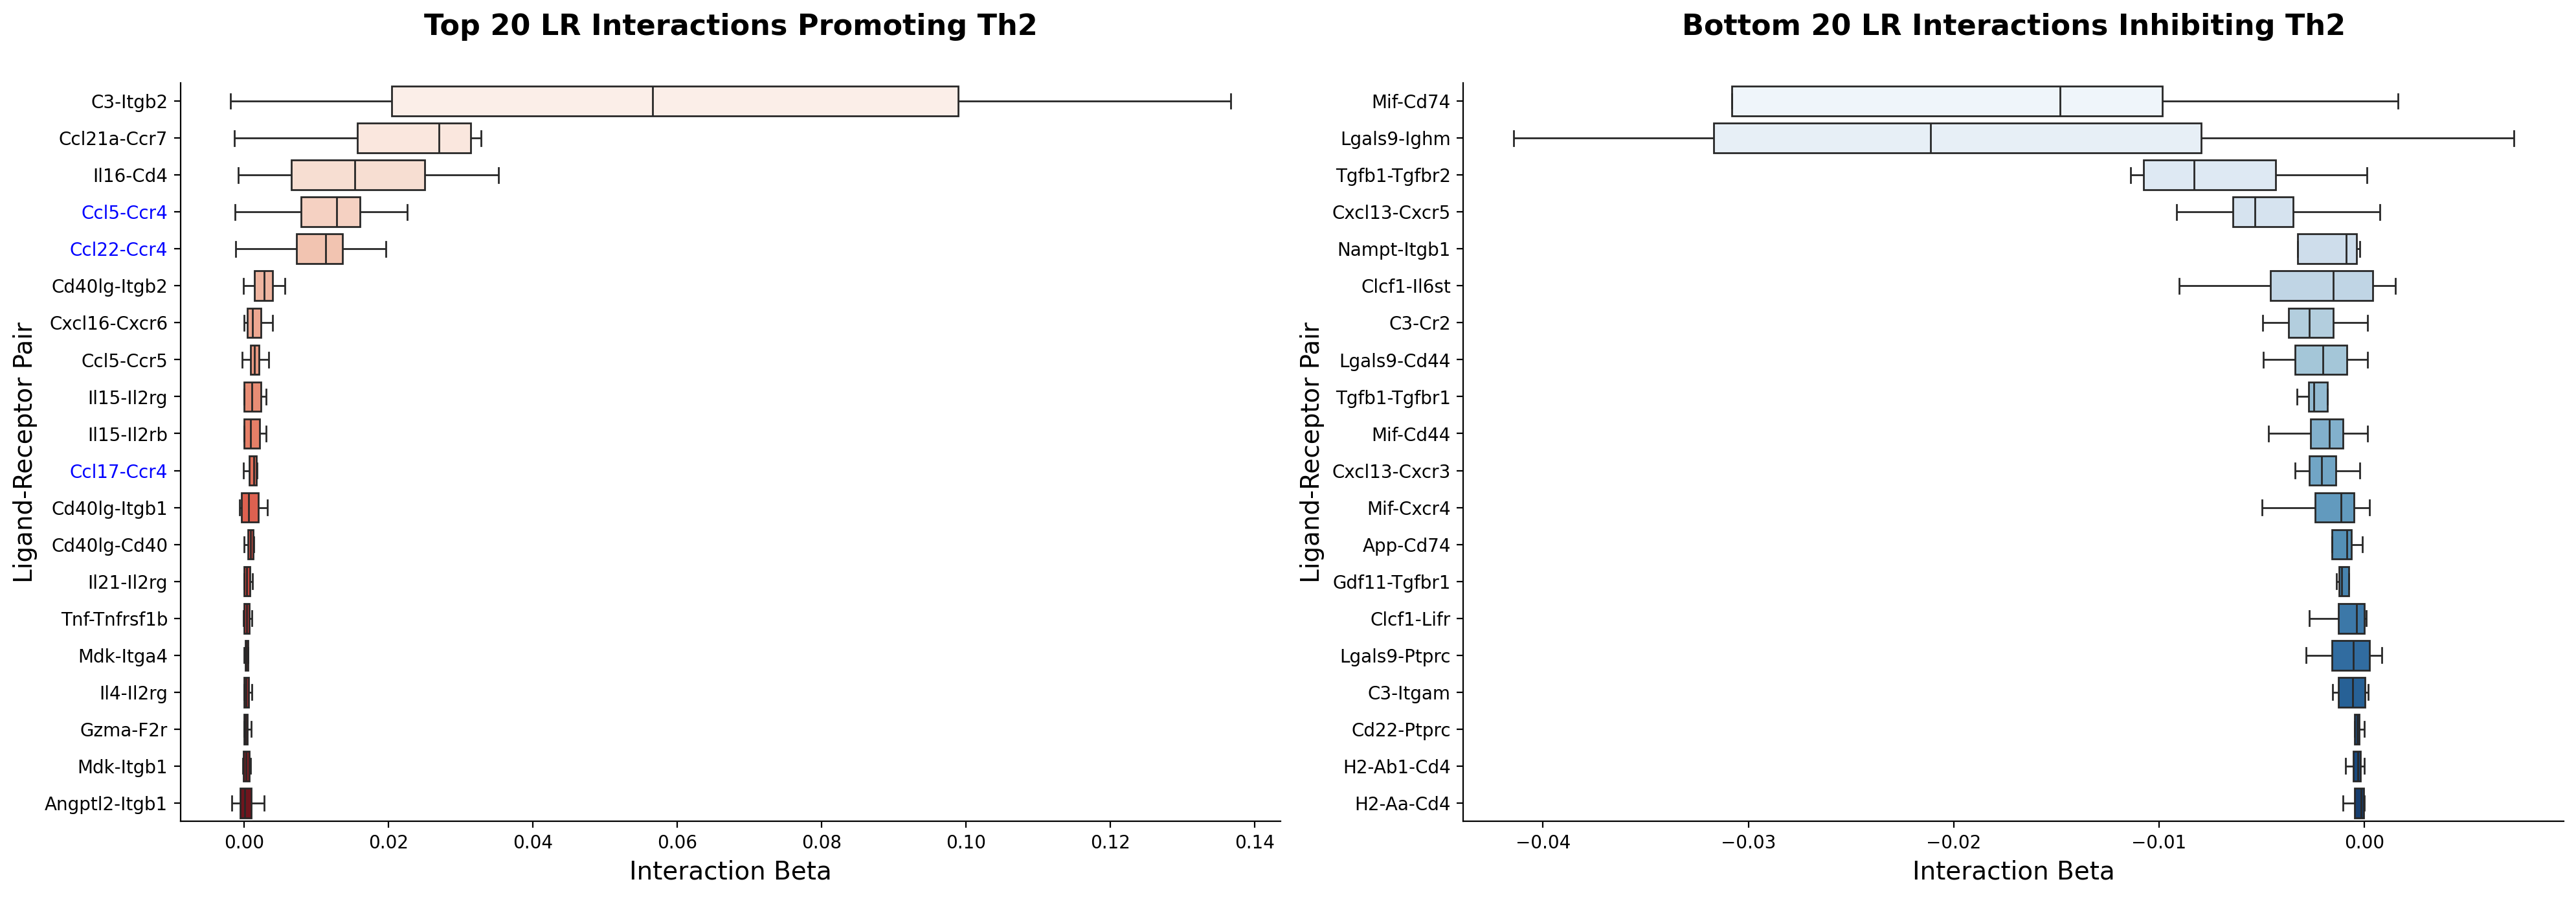

In [57]:
plot_lr_interactions(th2_interxns, 'Th2')
plt.savefig(f'{sample}_th2_betas.svg', bbox_inches='tight', dpi=300, transparent=True, format='svg')

### Find modulator to counteract Ccr4 KO

In [7]:
adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata

AnnData object with n_obs × n_vars = 89296 × 2116
    obs: 'sample', 'cell_type', 'secondary_annot', 'cell_type_int', 'x_umap', 'y_umap', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_features', 'spatial_maps', 'spatial_unscaled'
    layers: 'corrected_count', 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [8]:
delta_pred = pd.read_csv('delta_pred.csv', index_col=0)
if 'Ccr4' in delta_pred.index:
    delta_pred.drop('Ccr4', axis=0, inplace=True)
delta_pred.sort_values(by='0', key=abs, ascending=False).head(10)

,0
H2-Aa,0.000134
H2-Ab1,0.000116
Cd74,0.000094
Sh2d2a,-0.000064
Ctla4,-0.000057
H2-Eb1,0.000051
Cd3g,-0.000049
Ccl22,-0.000042
Cd3d,-0.000030
Cd79b,0.000028


In [9]:
up_genes = delta_pred.sort_values(by='0', ascending=False).head(10).index
down_genes = delta_pred.sort_values(by='0', ascending=True).head(10).index

In [10]:
data = {}
betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

for gene in up_genes:
    data[gene] = pd.concat([
        pd.read_parquet(betadir + f'mouse_lymph1{part}_visiumHD/' + gene + '_betadata.parquet') for part in ['a', 'b', 'c', 'd']
    ])

data.keys()

dict_keys(['H2-Aa', 'H2-Ab1', 'Cd74', 'H2-Eb1', 'Cd79b', 'H2-Ob', 'Syk', 'Snx29', 'Fcer2a', 'Pax5'])

In [11]:
# # find transferred cells (Prdm1+ Th2)
tmp = adata[:, ['Prdm1']].to_df(layer='raw_count')
prdm1 = tmp[tmp['Prdm1'] > 0].index

th2 = adata[((adata.obs['cell_type'] == 'Th2')), :].obs.index
th2 = adata[((adata.obs['cell_type'] == 'Tfh')), :].obs.index
treg = adata[((adata.obs['cell_type'] == 'Treg')), :].obs.index


transferred = (set(th2) | set(treg) | set(treg)) & set(prdm1)
# transferred = list(transferred)
# len(transferred)

transferred = list(transferred)
len(transferred)

77

In [12]:
data = {k: v.loc[transferred, :] for k, v in data.items()}

In [13]:
def plot_lr_interactions(interactions_df, cell_type):
    """
    Plot top and bottom 20 ligand-receptor interactions for a given cell type using boxplots.
    
    Parameters:
    -----------
    interactions_df : pandas.DataFrame
        DataFrame containing interaction betas
    cell_type : str
        Name of the cell type to analyze
    """
    # Compute mean interaction for each LR pair
    means = interactions_df.mean(axis=0)
    
    # Get top and bottom 20
    top20 = means.sort_values(ascending=False)[means > 0].head(20).index
    bottom20 = means.sort_values(ascending=True)[means < 0].head(20).index
    selected = list(top20) + list(bottom20)
    # Subset and melt for seaborn
    plot_df = interactions_df[selected].melt(var_name='Ligand-Receptor', value_name='Beta')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Plot top 20 interactions
    top_df = plot_df[plot_df['Ligand-Receptor'].isin(top20)]
    top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=top_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Reds',
        showfliers=False,
        ax=ax1
    )
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
    ax1.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax1.set_xlabel('Interaction Beta', fontsize=14)
    ax1.set_title(f'Top 20 modulators for {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Plot bottom 20 interactions
    bottom_df = plot_df[plot_df['Ligand-Receptor'].isin(bottom20)]
    bottom_df['Ligand-Receptor'] = bottom_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')

    sns.boxplot(
        data=bottom_df,
        y='Ligand-Receptor',
        x='Beta',
        palette='Blues',
        showfliers=False,
        ax=ax2
    )
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10)
    ax2.set_ylabel('Ligand-Receptor Pair', fontsize=14)
    ax2.set_xlabel('Interaction Beta', fontsize=14)
    ax2.set_title(f'Bottom 20 modulators for {cell_type}', fontsize=16, weight='bold', y=1.05)
    
    # Color CCR4 text blue if present
    for ax in [ax1, ax2]:
        for label in ax.get_yticklabels():
            if 'Ccr4' in label.get_text():
                label.set_color('blue')
    
    plt.tight_layout()
    sns.despine()

    return top_df, bottom_df

In [17]:
slideseq_adata = sc.read_h5ad(f'/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
common_genes = set(slideseq_adata.var_names) & set(adata.var_names)
len(common_genes)


568

/tmp/ipykernel_60285/3601978808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')
/tmp/ipykernel_60285/3601978808.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_60285/3601978808.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_60285/3601978808.py:44: SettingWithCopyWarning: 
A value is trying to b

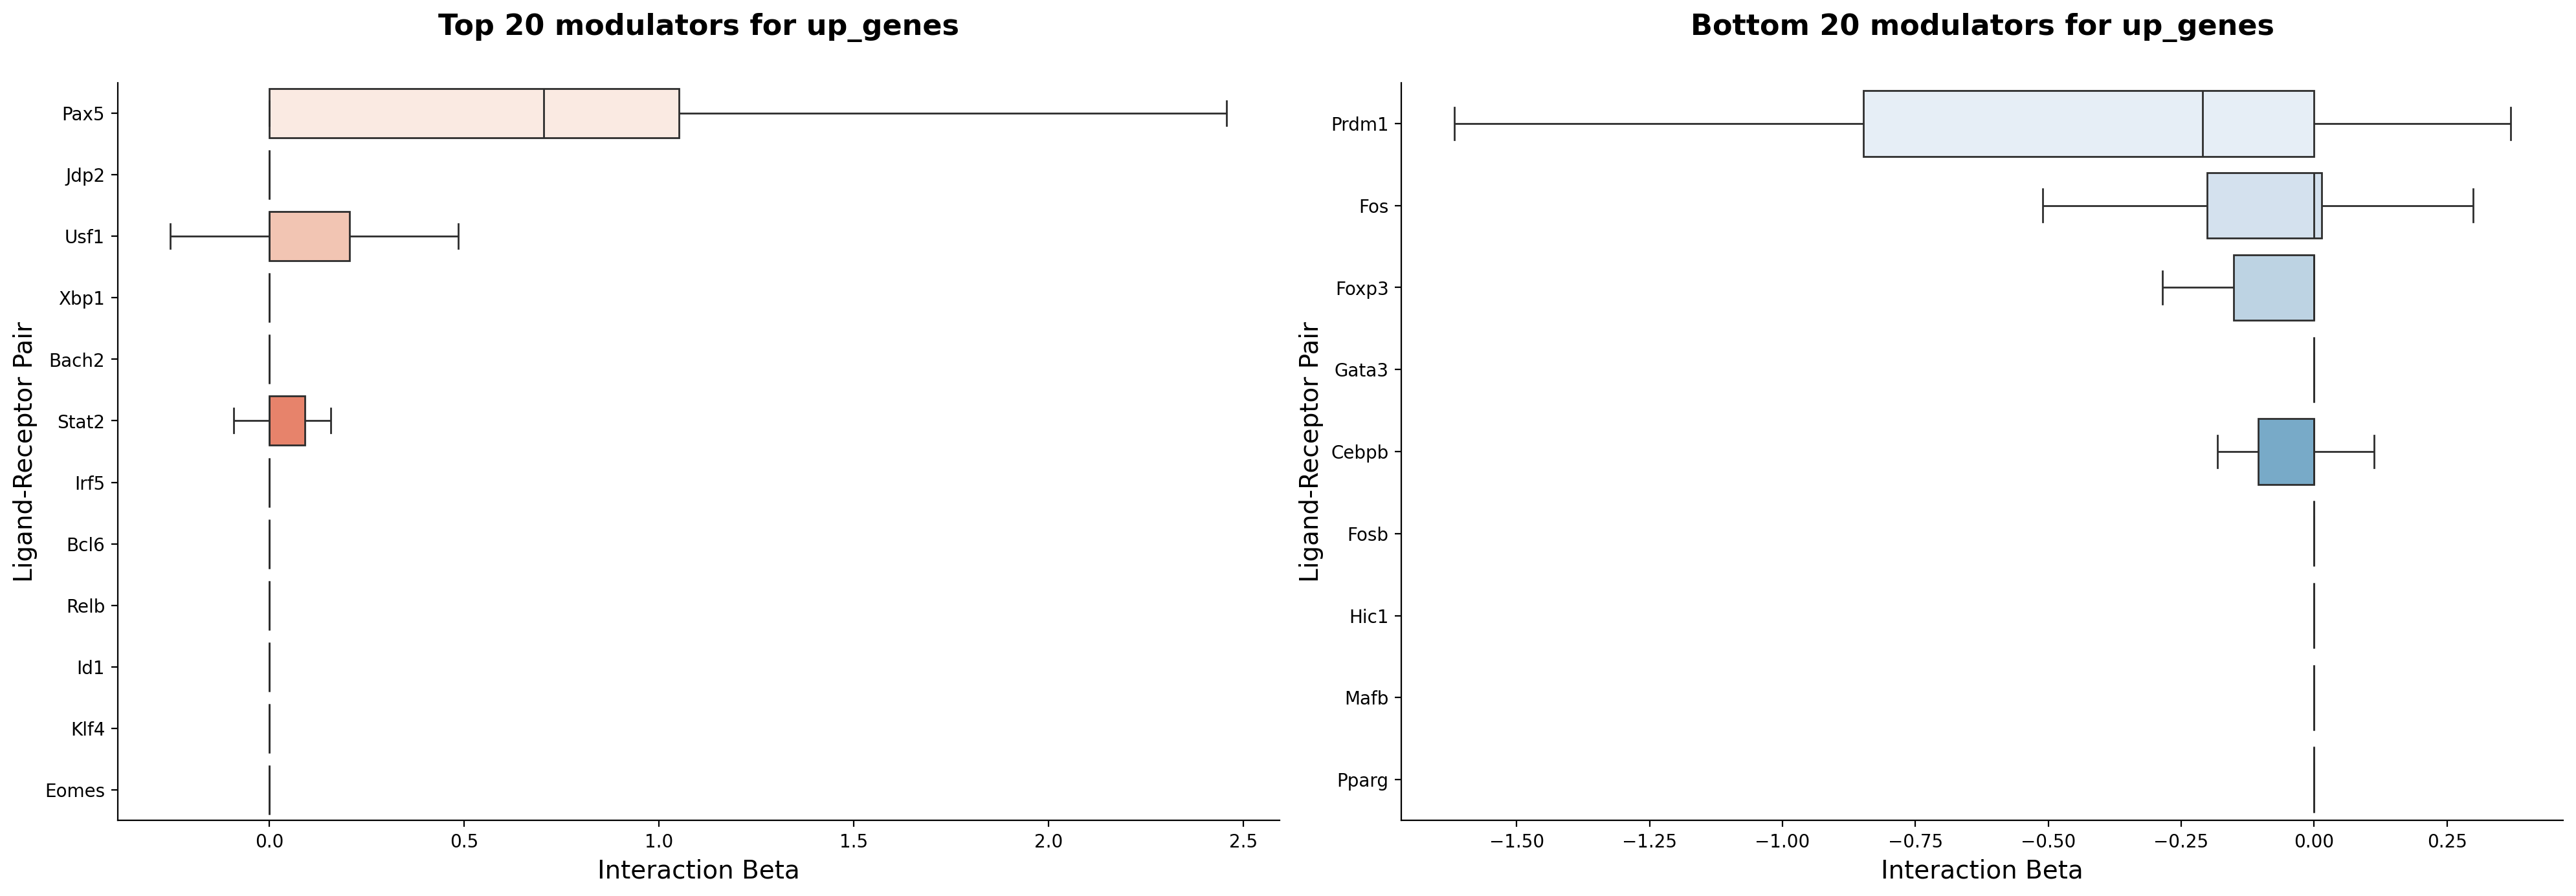

In [19]:
mod_betas = pd.concat([data[gene] for gene in up_genes], axis=0)
mod_betas = mod_betas.fillna(0)
mod_betas.drop(columns=['beta0'], inplace=True)
mod_betas = mod_betas[[x for x in mod_betas.columns if x.replace('beta_', '') in common_genes]]

top_df, bottom_df = plot_lr_interactions(mod_betas, 'up_genes')

In [61]:
data = {}
betadir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/'

for gene in down_genes:
    data[gene] = pd.concat([
        pd.read_parquet(betadir + f'mouse_lymph1{part}_visiumHD/' + gene + '_betadata.parquet') for part in ['a', 'b', 'c', 'd']
    ])

data.keys()

dict_keys(['Ctla4', 'Thy1', 'Lck', 'Il2rb', 'Ms4a6b', 'Cd5', 'Ms4a4b', 'Itgb7', 'Cap1', 'Icos'])

In [62]:
data = {k: v.loc[transferred, :] for k, v in data.items()}

/tmp/ipykernel_220629/1908793520.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')
/tmp/ipykernel_220629/1908793520.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_220629/1908793520.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_220629/1908793520.py:44: SettingWithCopyWarning: 
A value is trying 

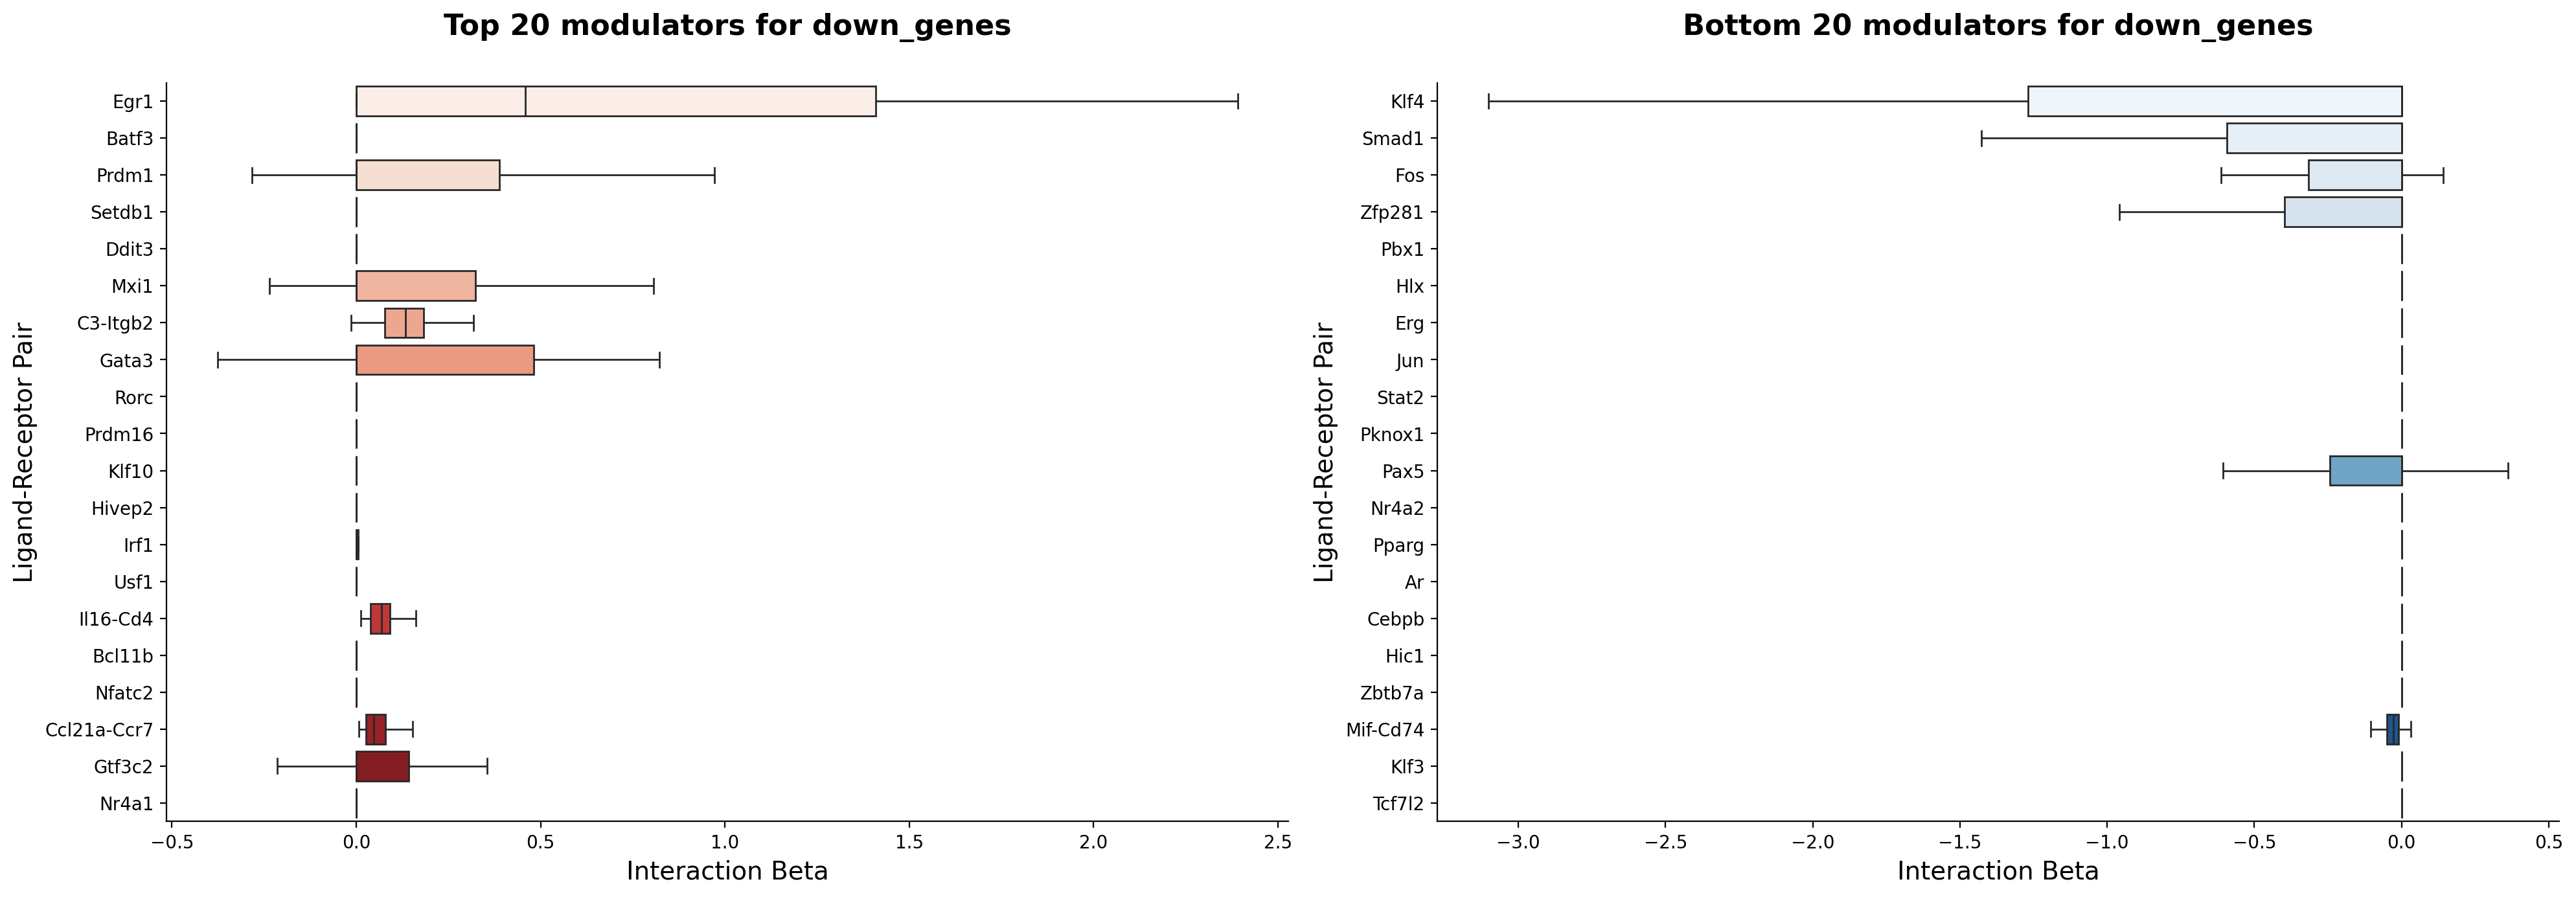

In [63]:
mod_betas = pd.concat([data[gene] for gene in down_genes], axis=0)
mod_betas = mod_betas.fillna(0)
mod_betas.drop(columns=['beta0'], inplace=True)

plot_lr_interactions(mod_betas, 'down_genes')

/tmp/ipykernel_220629/1908793520.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Ligand-Receptor'] = top_df['Ligand-Receptor'].str.replace('beta_', '').str.replace('$', '-').str.replace('_', '-')
/tmp/ipykernel_220629/1908793520.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_220629/1908793520.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_220629/1908793520.py:44: SettingWithCopyWarning: 
A value is trying 

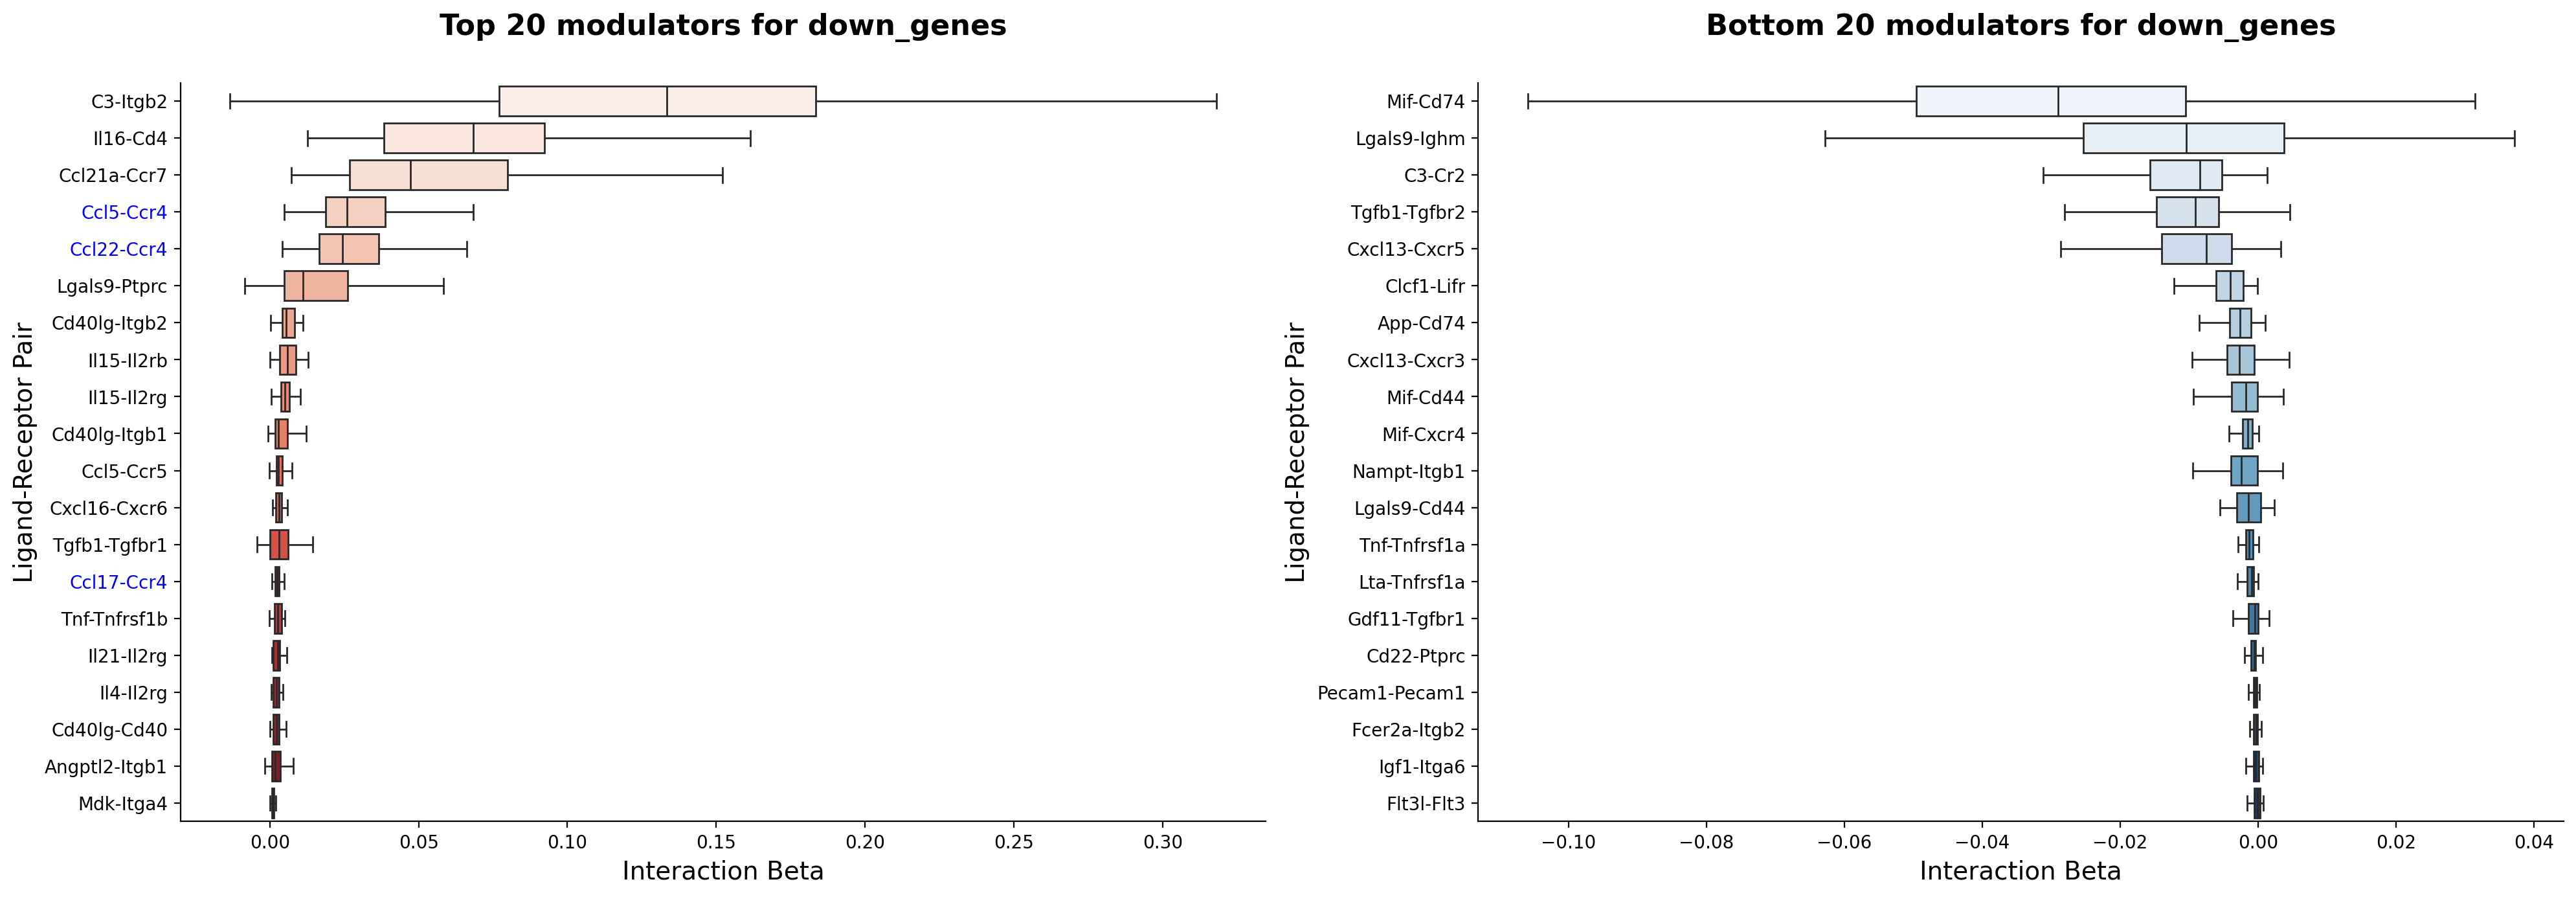

In [64]:
mod_interxns = mod_betas[[x for x in mod_betas.columns if '$' in x]]
plot_lr_interactions(mod_interxns, 'down_genes')


In [76]:
import commot as ct 
from spaceoracle.tools.network import expand_paired_interactions

df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
) 
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)
lr = lr[lr.ligand.isin(adata.var_names) &\
    (lr.receptor.isin(adata.var_names))]

2025-06-25 11:39:58.022225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [78]:
lr[lr.ligand == 'Ccl21a']

,ligand,receptor,pathway,signaling
654,Ccl21a,Ccr7,CCL,Secreted Signaling
